In [221]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
from nltk.tokenize import word_tokenize

In [223]:
from IPython.display import display

In [224]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
SAMPLE_SUBMISSION = 'data/sample_submission.csv'
RANDOM_STATE = 25
COLORS = plt.cm.cool_r(np.linspace(0, 1, 10))

! Multioutput regression

In [225]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [226]:
train.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [227]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


In [228]:
FEATURE_COLUMNS = ['full_text']
TARGET_COLUMNS = ['cohesion', 'syntax','vocabulary', 'phraseology', 'grammar','conventions']

In [229]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cohesion,3911.0,3.127077,0.662542,1.0,2.5,3.0,3.5,5.0
syntax,3911.0,3.028254,0.644399,1.0,2.5,3.0,3.5,5.0
vocabulary,3911.0,3.235745,0.583148,1.0,3.0,3.0,3.5,5.0
phraseology,3911.0,3.116850,0.655997,1.0,2.5,3.0,3.5,5.0
grammar,3911.0,3.032856,0.699841,1.0,2.5,3.0,3.5,5.0
conventions,3911.0,3.081053,0.671450,1.0,2.5,3.0,3.5,5.0


#### Target variables

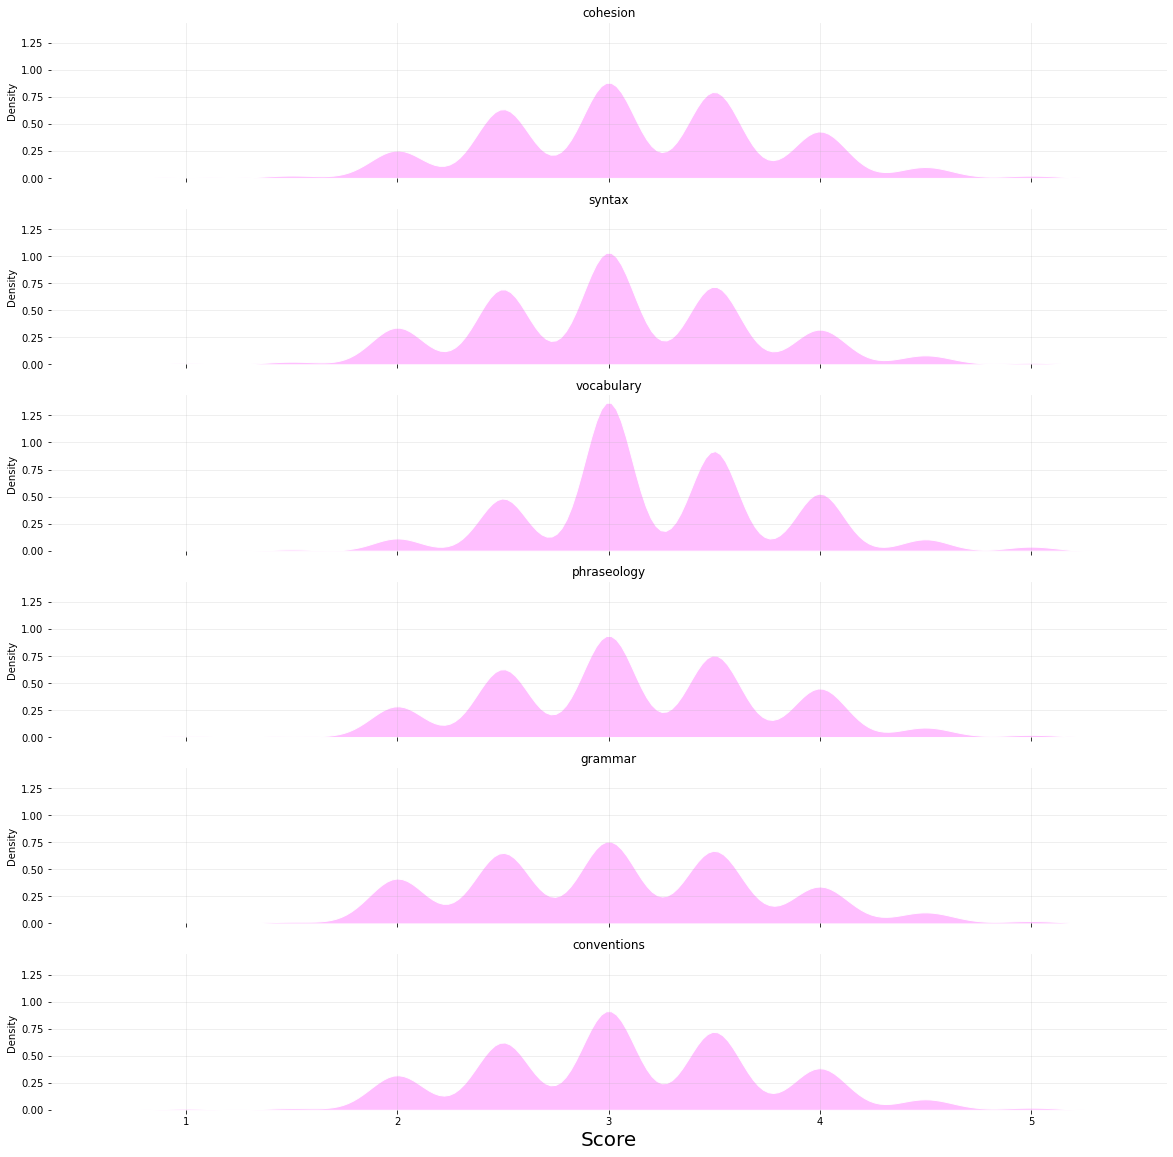

In [230]:
fig, axs = plt.subplots(nrows=len(TARGET_COLUMNS), ncols = 1, figsize = (20, 20), sharex = True, sharey = True)

for idx, target_col in enumerate(TARGET_COLUMNS):
    axs[idx].set_title(target_col)
    sns.kdeplot(train[target_col], color = COLORS[0], ax = axs[idx], fill = True, edgecolor = 'white', label = target_col)
    axs[idx].set_frame_on(False)
    axs[idx].grid(True, alpha = .25)

plt.xlabel('Score', fontsize = 20)
plt.show()

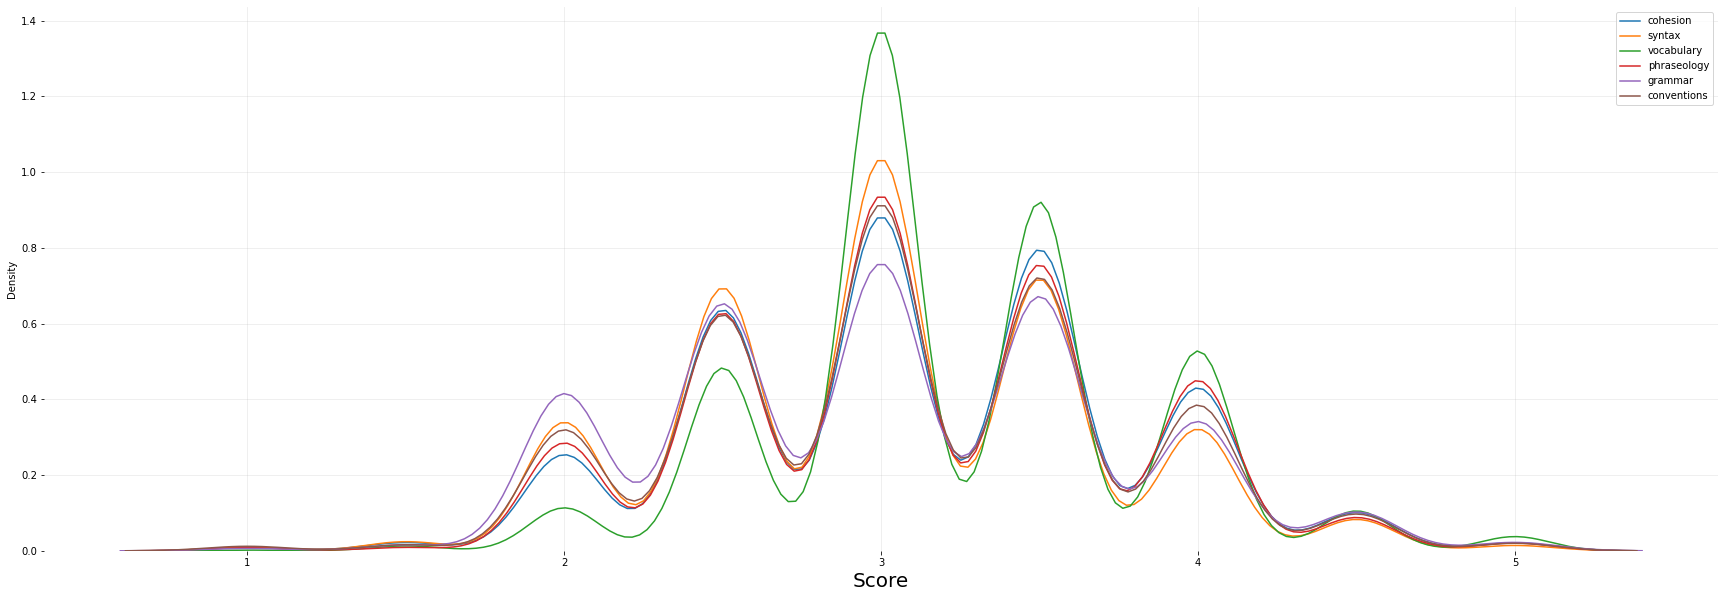

In [231]:
fig = plt.figure(figsize = (30, 10))

for idx, target_col in enumerate(TARGET_COLUMNS):
    sns.kdeplot(train[target_col], palette='cool_r', fill = False, label = target_col, )

plt.box(False)
plt.grid(True, alpha = .25)
plt.xlabel('Score', fontsize = 20)
plt.legend()
plt.show()

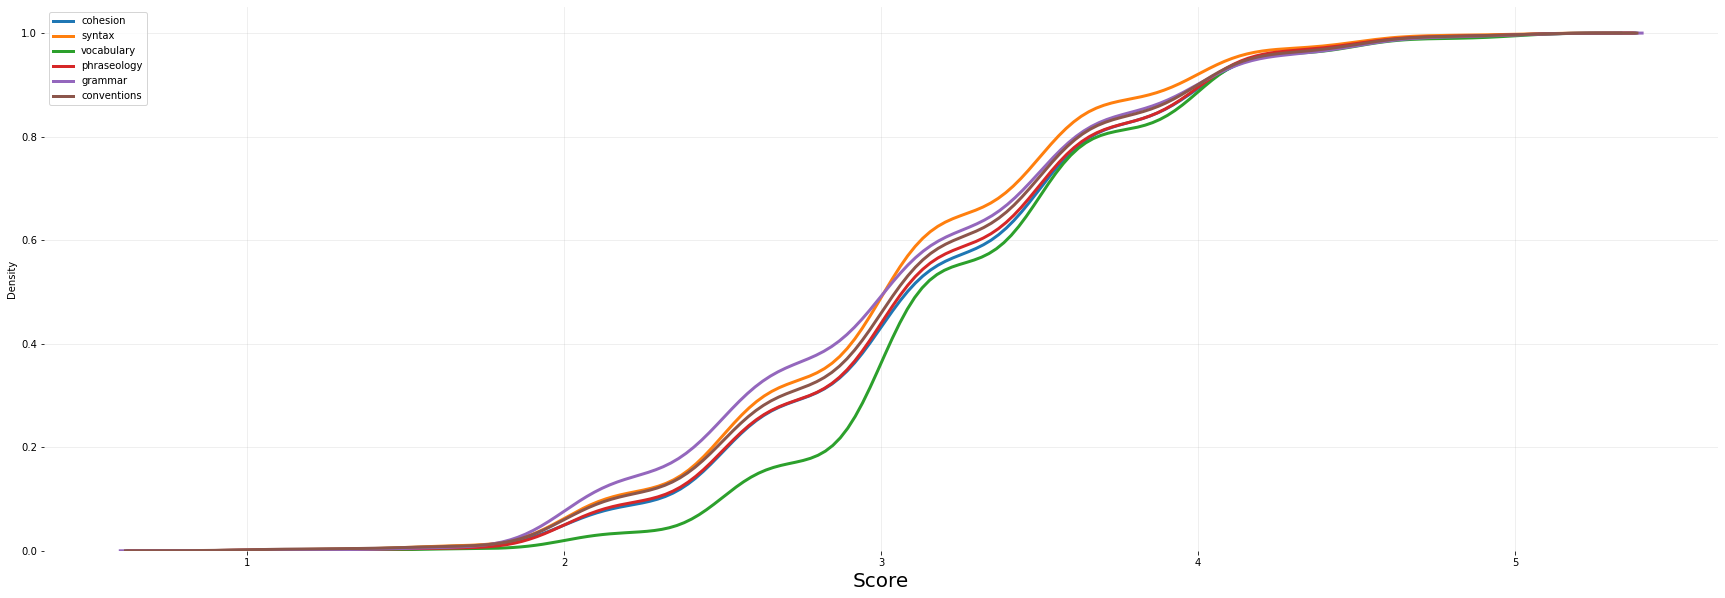

In [253]:
fig = plt.figure(figsize = (30, 10))

for idx, target_col in enumerate(TARGET_COLUMNS):
    sns.kdeplot(train[target_col], palette='cool_r', fill = False, label = target_col, cumulative=True, linewidth = 3)

plt.box(False)
plt.grid(True, alpha = .25)
plt.xlabel('Score', fontsize = 20)
plt.legend()
plt.show()

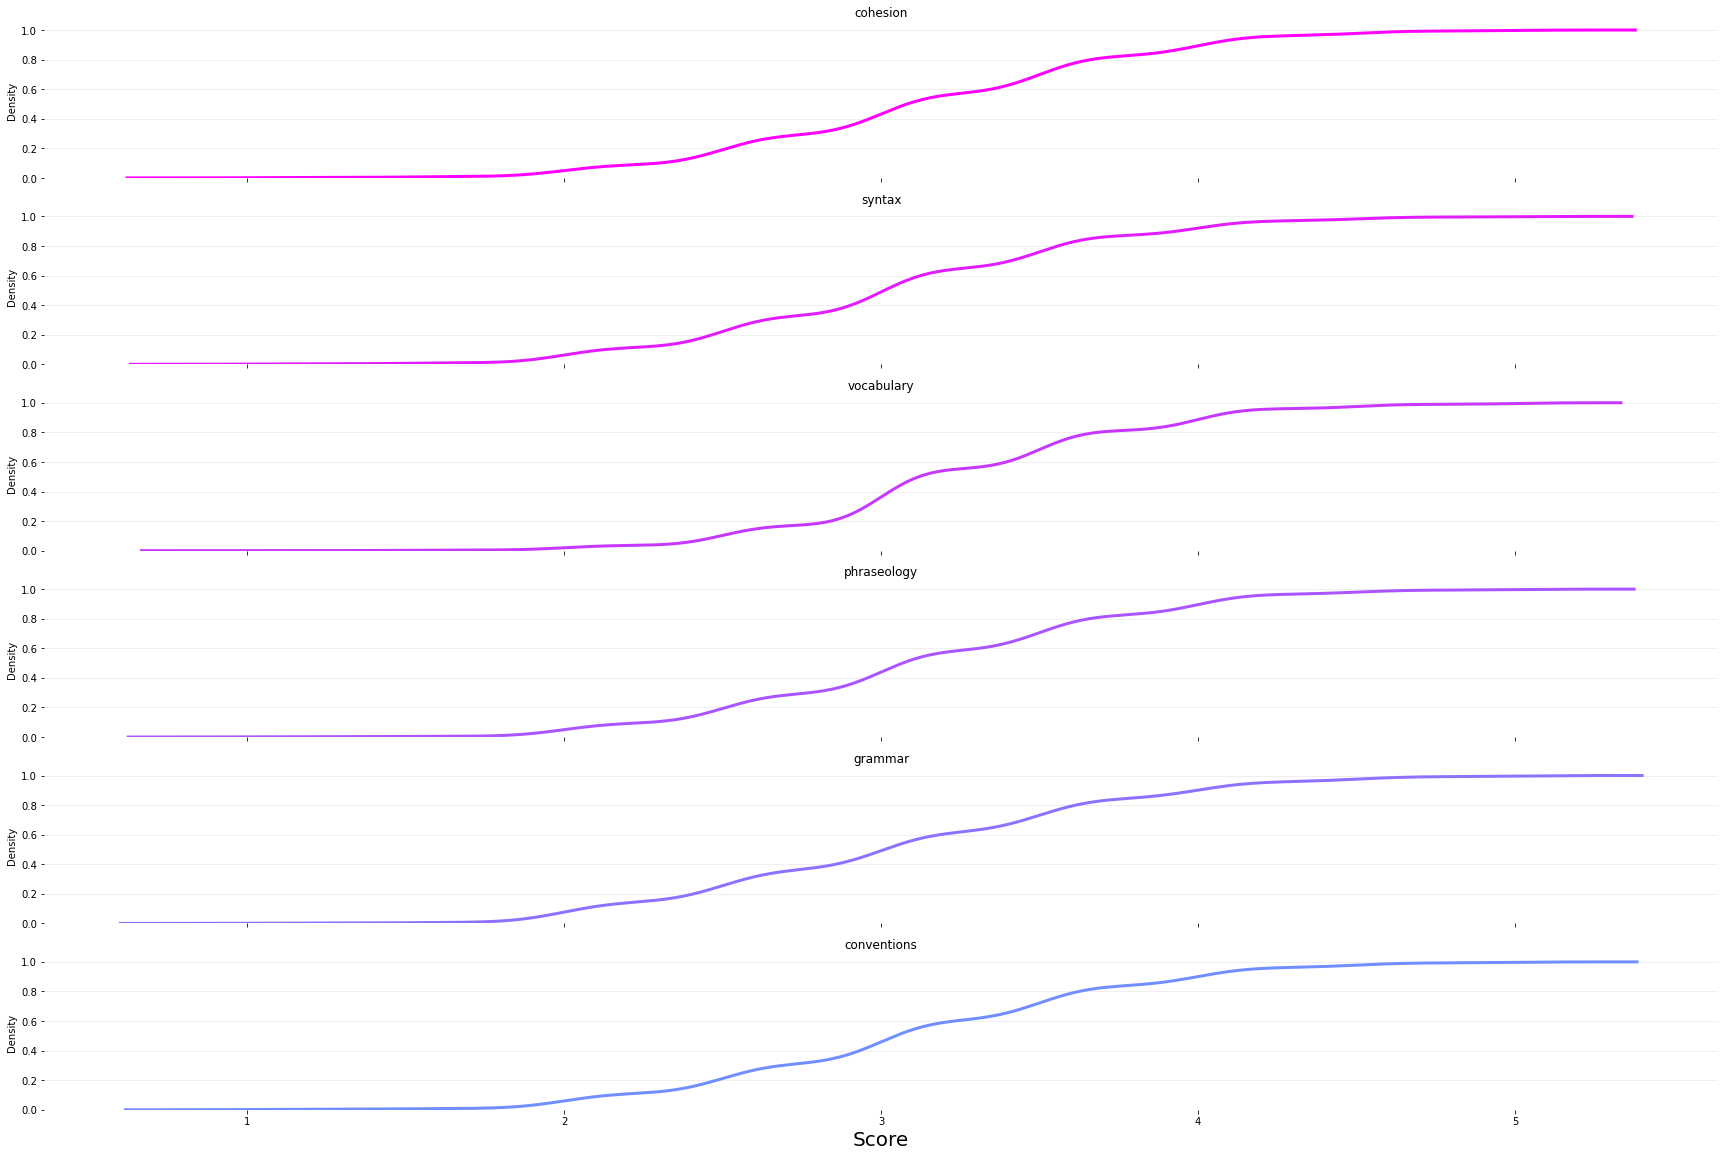

In [233]:
fig, axs = plt.subplots(nrows=len(TARGET_COLUMNS), ncols = 1, figsize = (30, 20), sharex = True, sharey = True)

for idx, target_col in enumerate(TARGET_COLUMNS):
    sns.kdeplot(train[target_col], color=COLORS[idx], fill = False, label = target_col, cumulative=True, linewidth = 3, ax = axs[idx]).set_title(target_col)
    axs[idx].set_frame_on(False)
    axs[idx].grid(axis='y', alpha = .25)

plt.xlabel('Score', fontsize = 20)
plt.show()

In [234]:
for idx, col in enumerate(train[TARGET_COLUMNS]):
    print(f"{idx}, {col} \n\t\t{sorted(train[col].unique())}")

0, cohesion 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
1, syntax 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
2, vocabulary 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
3, phraseology 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
4, grammar 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
5, conventions 
		[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Density plots might be inappropriate as there are basically 9 unique values for each target category.

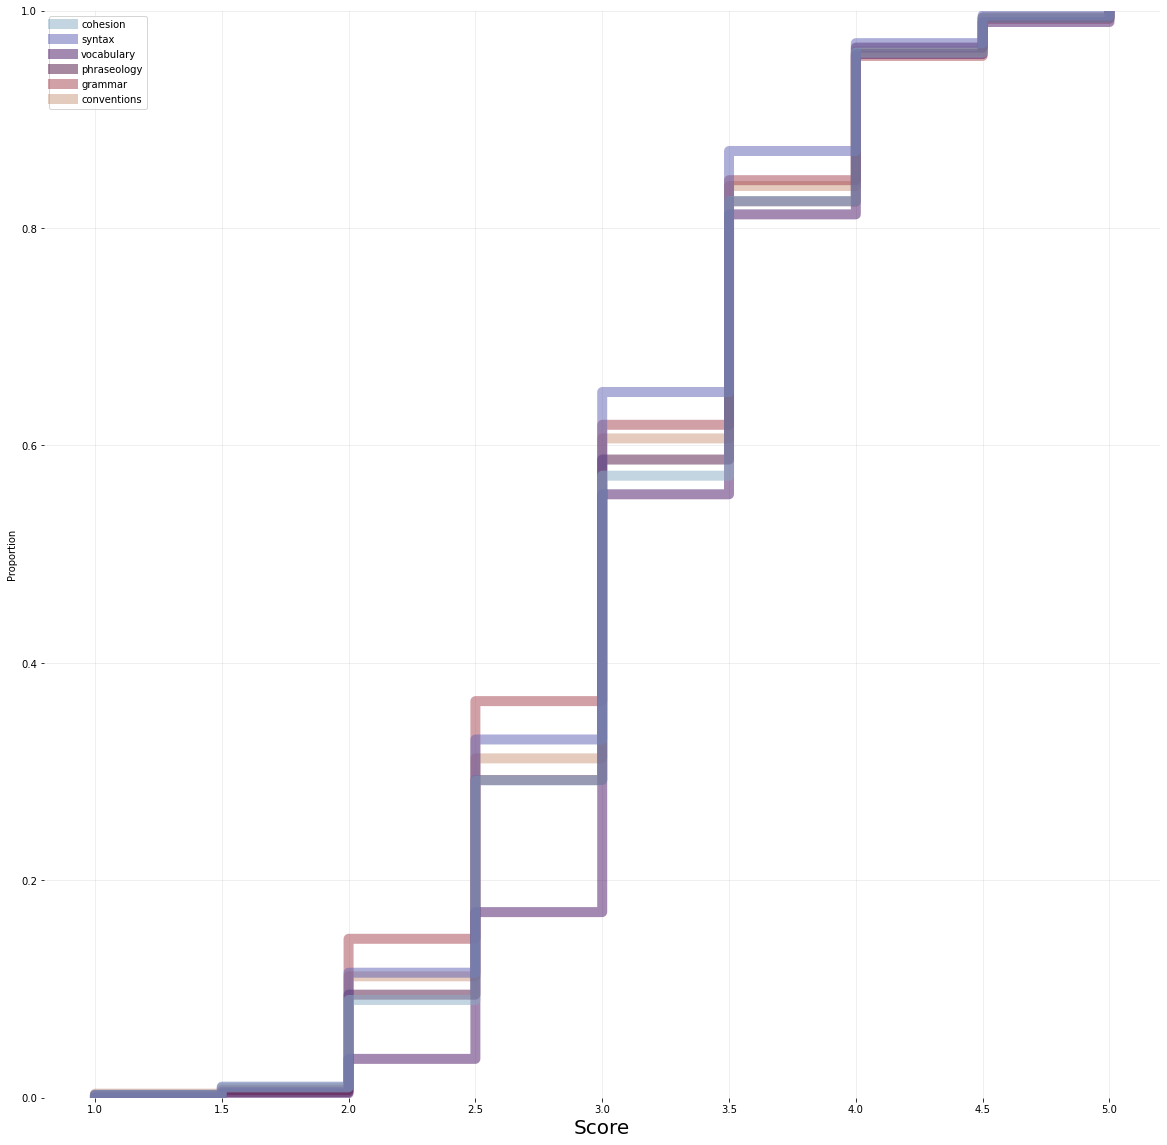

In [235]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 20))
sns.ecdfplot(train[TARGET_COLUMNS], palette='twilight', ax = axs, linewidth = 10, alpha = .5)

plt.xlabel('Score', fontsize = 20)
plt.box(False)
plt.grid(True, alpha = .25)
plt.show()

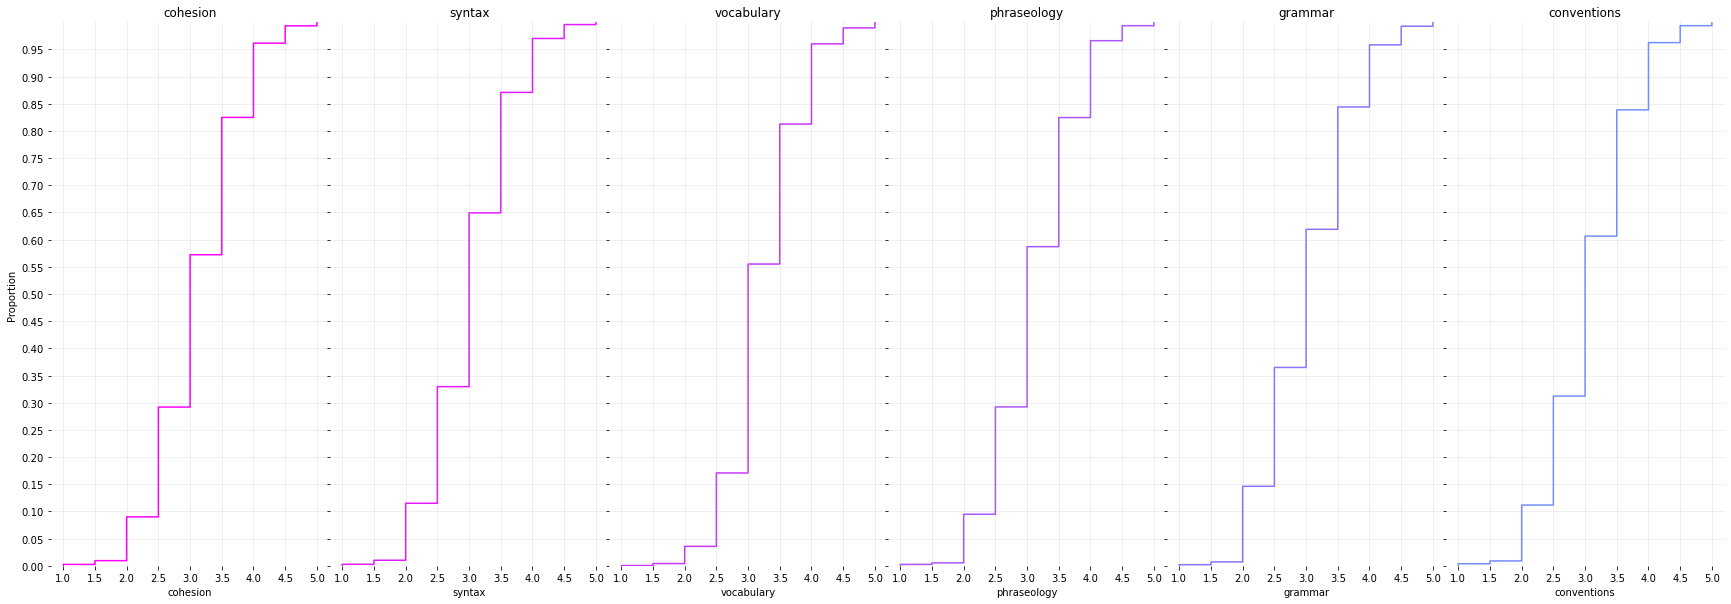

In [236]:
fig, axs = plt.subplots(nrows=1, ncols = len(TARGET_COLUMNS), figsize = (30, 10), sharex = True, sharey = True)

axs[idx].set_xticks(np.linspace(1,5,9))
for idx, target_col in enumerate(TARGET_COLUMNS):
    axs[idx].set_title(target_col)
    sns.ecdfplot(train[target_col], color = COLORS[idx], ax = axs[idx], label = target_col)
    axs[idx].set_frame_on(False)
    
    axs[idx].set_yticks(np.arange(0,1,.05))
    axs[idx].grid(True, alpha =.25)
plt.subplots_adjust(wspace = 0)
plt.show()

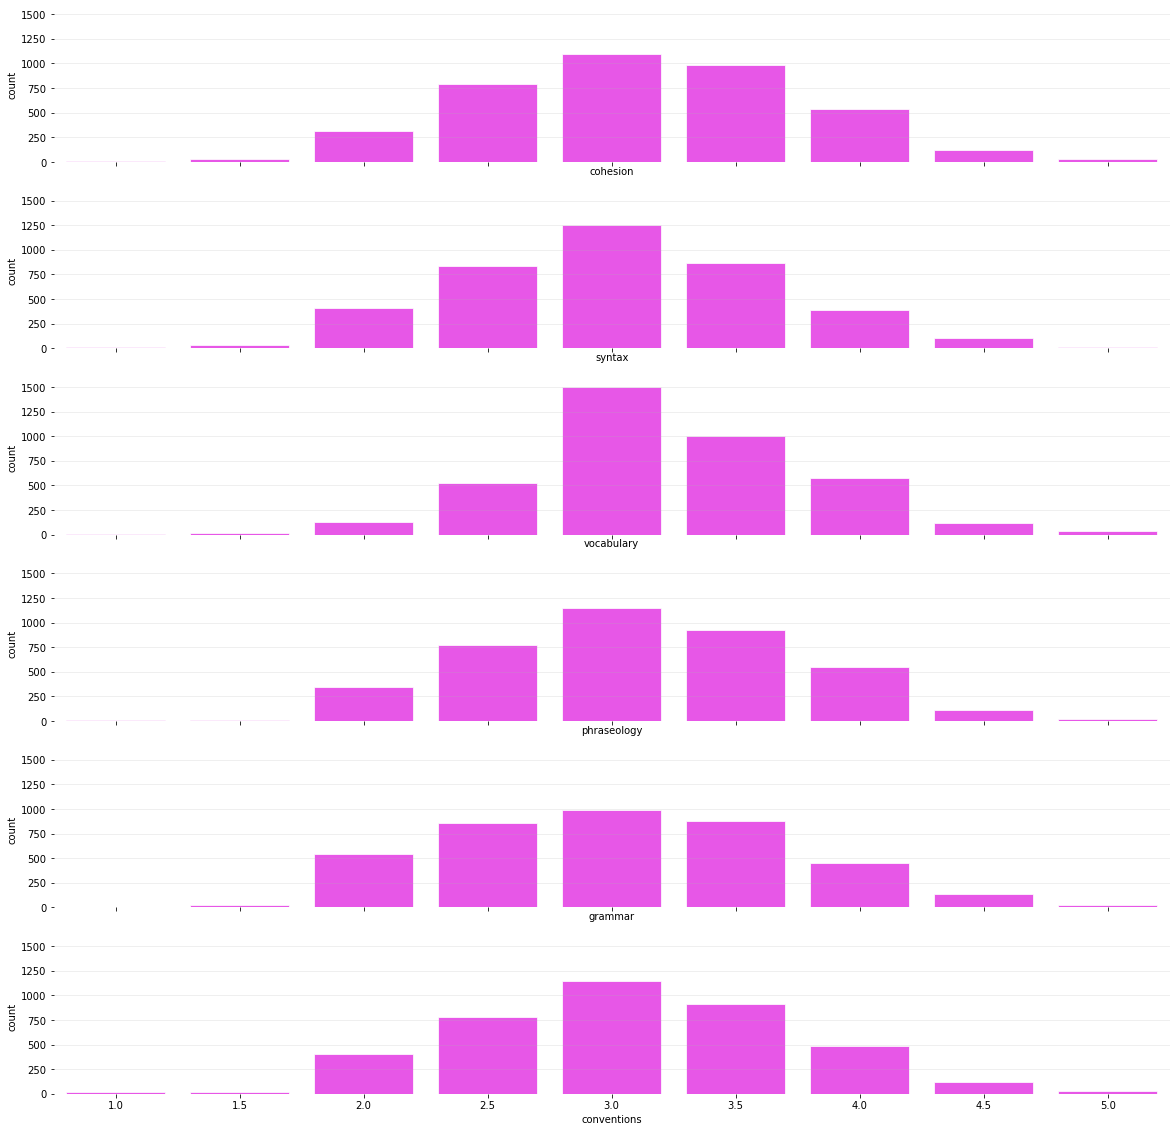

In [237]:
fig, axs = plt.subplots(nrows=len(TARGET_COLUMNS), ncols = 1, figsize = (20, 20), sharex = True, sharey = True)

for idx, target_col in enumerate(TARGET_COLUMNS):
    sns.countplot(x = train[target_col], color = COLORS[0],  ax = axs[idx], edgecolor = 'white', label = target_col, alpha = .75, )
    axs[idx].set_frame_on(False)
    axs[idx].grid(axis='y', alpha = .25)

plt.show()

In [238]:
train['target_sum'] = train[TARGET_COLUMNS].sum(axis = 1)

In [239]:
train['target_sum'].describe()

count    3911.000000
mean       18.621836
std         3.365642
min         6.000000
25%        16.000000
50%        18.500000
75%        21.000000
max        30.000000
Name: target_sum, dtype: float64

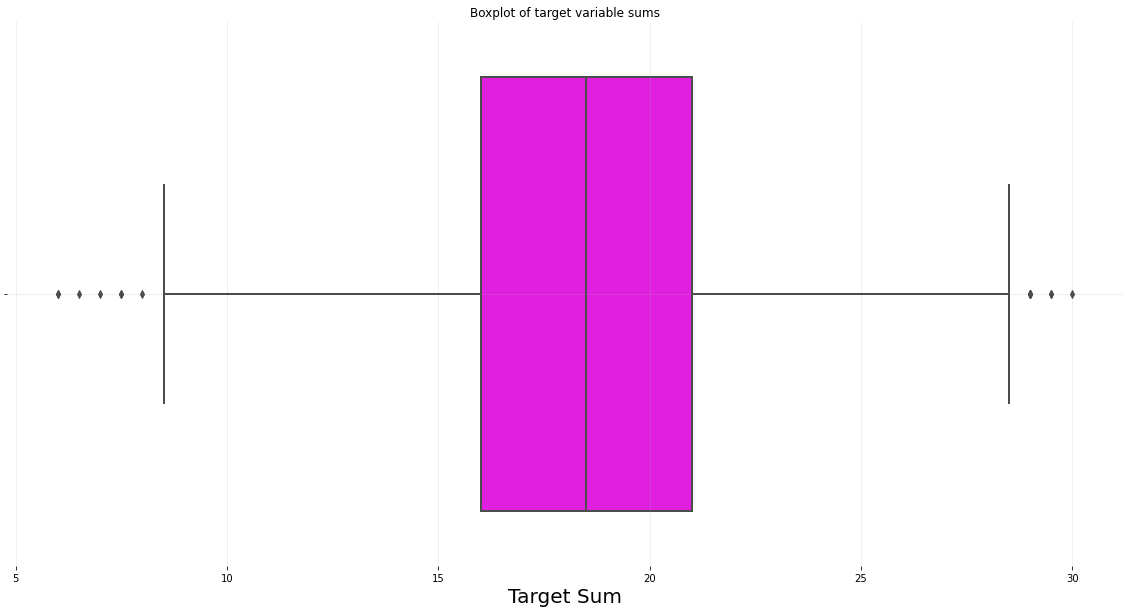

In [240]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
sns.boxplot(x = train['target_sum'], color = COLORS[0], ax = axs, linewidth = 2).set_title('Boxplot of target variable sums')

plt.xlabel('Target Sum', fontsize = 20)

plt.box(False)
plt.grid('xaxis', alpha = .25)
plt.show()

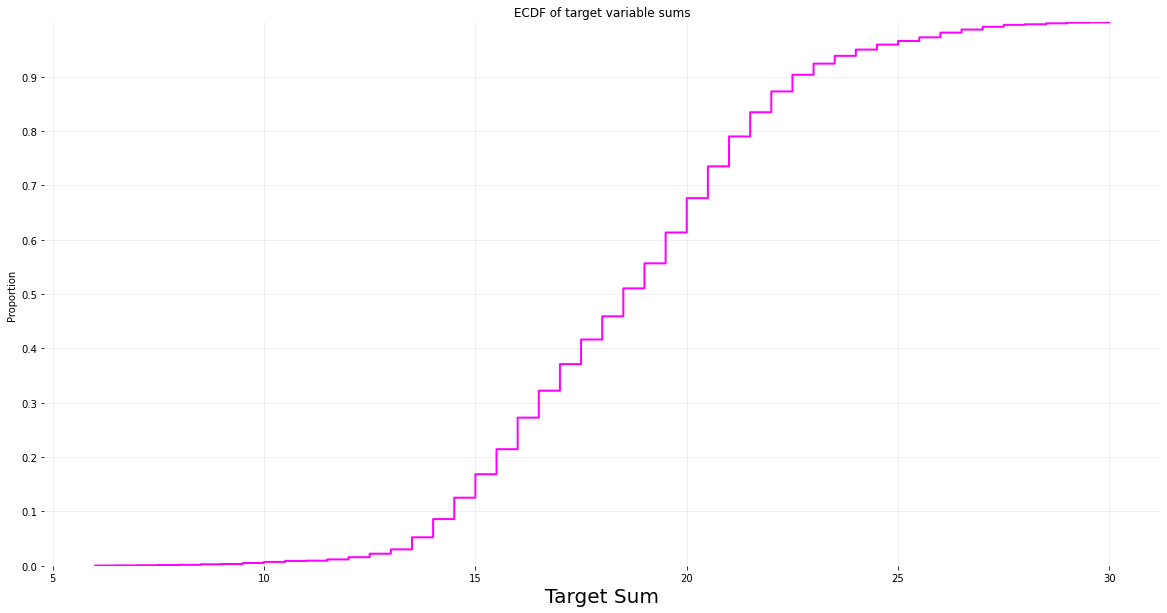

In [241]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
sns.ecdfplot(x = train['target_sum'], color = COLORS[0], ax = axs, linewidth = 2).set_title('ECDF of target variable sums')

plt.xlabel('Target Sum', fontsize = 20)

axs.set_yticks(np.arange(0,1,.1))
plt.box(False)
plt.grid('xaxis', alpha = .25)
plt.show()

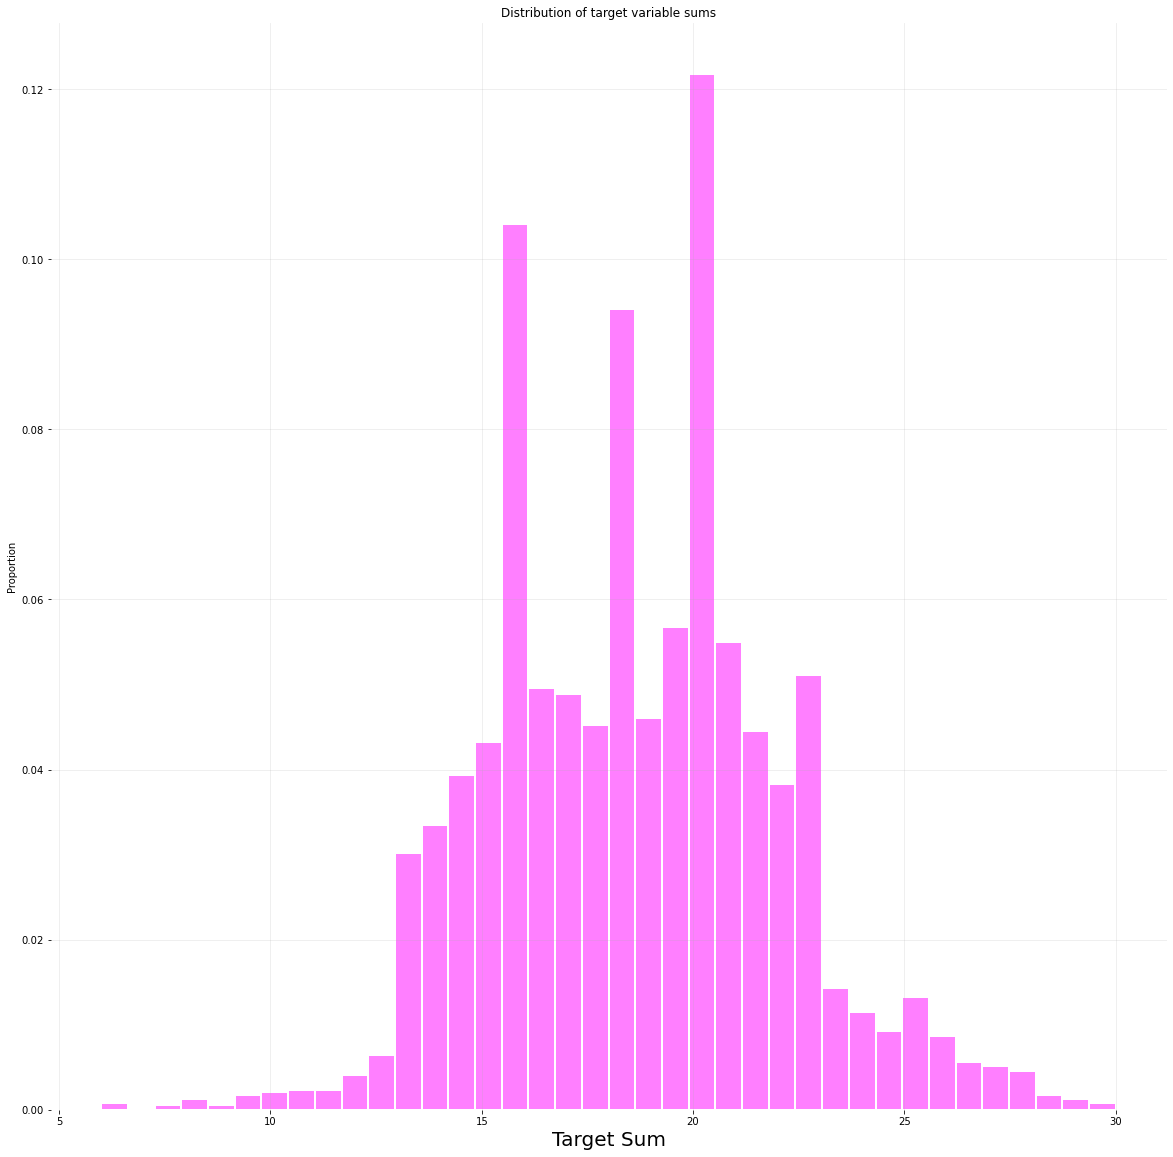

In [242]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 20))
sns.histplot(train['target_sum'], color = COLORS[0], ax = axs, linewidth = 2, edgecolor = 'white', alpha = .5, stat = 'proportion').set_title('Distribution of target variable sums')

plt.xlabel('Target Sum', fontsize = 20)
plt.box(False)
plt.grid(True, alpha = .25)
plt.show()

### Text

In [243]:
tokenized_texts = train.full_text.map(word_tokenize)

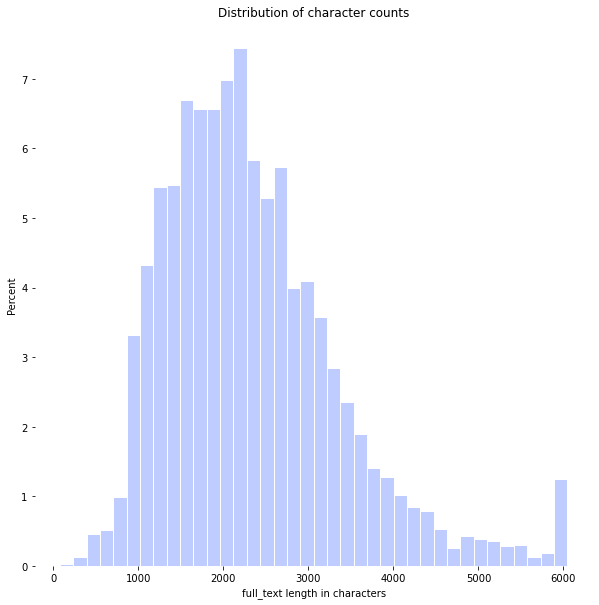

In [244]:
fig = plt.figure(figsize=(10, 10))
sns.histplot(train.full_text.str.len(), color = COLORS[-5], alpha = .45, edgecolor = 'white', stat = 'percent')
plt.xlabel(f'full_text length in characters')
plt.title('Distribution of character counts')
plt.box(False)
plt.show()

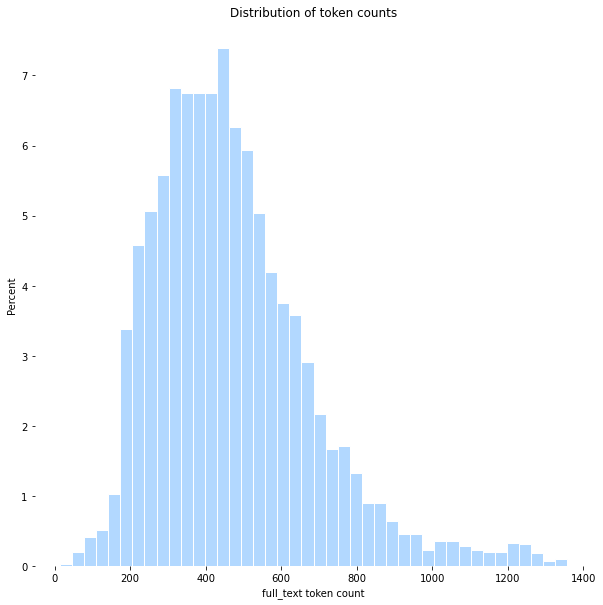

In [245]:
fig = plt.figure(figsize=(10, 10))
sns.histplot(tokenized_texts.map(len), color = COLORS[-4], alpha = .45, edgecolor = 'white', stat = 'percent')
plt.xlabel(f'full_text token count')
plt.title('Distribution of token counts')
plt.box(False)
plt.show()

In [255]:
# Let's check out some samples

sample_good = train.loc[train.target_sum > 25].full_text.sample(5, random_state=RANDOM_STATE)
sample_average = train.loc[(train.target_sum < 21.0) & (train.target_sum > 16.0)].full_text.sample(5, random_state=RANDOM_STATE)
sample_bad = train.loc[train.target_sum < 14].full_text.sample(5, random_state=RANDOM_STATE)


In [260]:
subset_of_interest_good = train.iloc[sample_good.index][TARGET_COLUMNS]
mean_scores_good = subset_of_interest_good.mean(axis = 1).sort_values(ascending = False)

subset_of_interest_average = train.iloc[sample_average.index][TARGET_COLUMNS]
mean_scores_average = subset_of_interest_average.mean(axis = 1).sort_values(ascending = False)

subset_of_interest_bad = train.iloc[sample_bad.index][TARGET_COLUMNS]
mean_scores_bad = subset_of_interest_bad.mean(axis = 1).sort_values(ascending = False)


In [261]:
# Examples for a text w/ a relative higher score (top 5%)
for idx in mean_scores_good.index:
    
    print(f"\n\t\tSample idx: {idx}")
    target_scores = train.iloc[idx][TARGET_COLUMNS]

    print(f"\n\t\tSum target score: {target_scores.sum():.2f}")
    print(f"\n\t\tMean target score: {target_scores.mean():.2f}")
    format_row = "{:>15}" * (len(target_scores) + 1)
    print(format_row.format("", *target_scores.index))
    print(format_row.format("", *target_scores.values))
    print(f'\n\n')
    print(train.iloc[idx].full_text)
    print(f'\n\n')
    print(100*'*')
    print(100*'*')



		Sample idx: 1765

		Sum target score: 29.00

		Mean target score: 4.83
                      cohesion         syntax     vocabulary    phraseology        grammar    conventions
                           4.5            5.0            5.0            4.5            5.0            5.0



Thomas Jefferson, writer of the Declaration of Independence and founding father of the United States, once said, "Determine never to be idle...it is wonderful how much may be done if we are always doing." In Jefferson's eyes, a world spent in constant work and motion represents a more productive and accomplished world. However, there is merit in a world that does not work without break and resolves to be idle at times. A world that is always working may also be a world that is burning out, diminishing the value of building connections and reflecting. A world that is idle when it recognizes its need to be has more value than a world that is always working, as it allows time for cognitive development and

In [262]:
# Examples for a text w/ a score from the middle two quartiles
for idx in mean_scores_average.index:
    
    print(f"\n\t\tSample idx: {idx}")
    target_scores = train.iloc[idx][TARGET_COLUMNS]

    print(f"\n\t\tSum target score: {target_scores.sum():.2f}")
    print(f"\n\t\tMean target score: {target_scores.mean():.2f}")
    format_row = "{:>15}" * (len(target_scores) + 1)
    print(format_row.format("", *target_scores.index))
    print(format_row.format("", *target_scores.values))
    print(f'\n\n')
    print(train.iloc[idx].full_text)
    print(f'\n\n')
    print(100*'*')
    print(100*'*')



		Sample idx: 276

		Sum target score: 20.50

		Mean target score: 3.42
                      cohesion         syntax     vocabulary    phraseology        grammar    conventions
                           4.0            2.5            4.0            3.0            3.5            3.5



As a student, I can say there are a lot benefits for a student from being able to attend classes from home, is really convenience for a student that some schools offer distance learning as an option, every school should have that opportunity; it ca be helpful for a lot of students, is good for students that does not have a lot of time, so that help them to have a flexible manage of time, in some cases the student are more successful by taking the classes online.

For example if some students have to work , and because their work's schedule take them a lot of time or they have to work at night, they do not feel like waking up earlier in the morning, sometimes they start to getting late to classes, missin

In [263]:
# Examples for a text w/ a relative lower score (~ bottom 10%)

for idx in mean_scores_bad.index:
    
    print(f"\n\t\tSample idx: {idx}")
    target_scores = train.iloc[idx][TARGET_COLUMNS]

    print(f"\n\t\tSum target score: {target_scores.sum():.2f}")
    print(f"\n\t\tMean target score: {target_scores.mean():.2f}")
    format_row = "{:>15}" * (len(target_scores) + 1)
    print(format_row.format("", *target_scores.index))
    print(format_row.format("", *target_scores.values))
    print(f'\n\n')
    print(train.iloc[idx].full_text)
    print(f'\n\n')
    print(100*'*')
    print(100*'*')


		Sample idx: 903

		Sum target score: 13.50

		Mean target score: 2.25
                      cohesion         syntax     vocabulary    phraseology        grammar    conventions
                           2.5            2.0            2.5            2.5            2.0            2.0



peple can changes they first impresion

In this ocation i am disagree with this statment because sometimes people act different like when I firt meet my grilfrind I

was thinking that she was a happy person but with the thime I see that she was not that happy my impresion changes of that situation.

The majority of the people act different when they meet some a person that they going to meet for example, when you going to see a job you need to act happy and smile to they can acept you but in realiti you are sad so with the timethey changes that first impresion.

So alot of people when they meet a person they have a diffferent impresion so the other person can think that she or he is happy or have a good